In [807]:
# Video games are sold all over the world which produces a large amount of data on user and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales. The goal of this project is to identify patterns that determine whether a game succeeds or not. This will allow identification of potential big winners and which games to plan advertising campaigns for. 

In [808]:
# Import packages needed for analysis of data
import pandas as pd
import plotly.express as px
import re
from matplotlib import pyplot as plt 
import numpy as np 

In [809]:
# Print info of DataFrame to get all attributes of table at once
DF = pd.read_csv("dataset.csv")
print(DF.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


In [810]:
# Rename column names to contain only lowercase letters
DF = DF.rename(
    columns={
        'Name': 'name',
        'Platform': 'platform',
        'Year_of_Release': 'year_of_release',
        'Genre': 'genre',
        'NA_sales': 'na_sales',
        'EU_sales': 'eu_sales',
        'JP_sales': 'jp_sales',
        'Other_sales': 'other_sales',
        'Critic_Score': 'critic_score',
        'User_Score': 'user_score',
        'Rating': 'rating'
    }
)

# Verify the change
print(DF.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None


In [811]:
# Change the 'user_score' column from object to float to be able to conduct mathematical equations (ex: mean score, min score, max score, std score)
DF['user_score'] = pd.to_numeric(DF['user_score'], errors='coerce')

# Verify the change
print(DF.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB
None


In [812]:
# Due to such a large dataset, it is not practical to display all the rows, thus we will print the first and last 5 rows.
# Print the first 5 rows for a small sample of data to give a quick snapshot of the structure of the dataset.
print(DF.head(5))

                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score rating  
0     28.96      3.77         8.45          76.0         8.0      E  
1      3.58      6.81         0.77           NaN         NaN    NaN  
2     12.76      3.79         3.29          82.0         8.3      E  
3     10.93      3.28         2.95          80.0         8.0      E  
4      8.89     10.22         1.00           NaN         NaN    NaN  


In [813]:
# Print last 5 rows for another sample of data to check if there are any special cases, outliers, or null values that weren't visible at the beginning.
print(DF.tail(5))

                                name platform  year_of_release       genre  \
16710  Samurai Warriors: Sanada Maru      PS3           2016.0      Action   
16711               LMA Manager 2007     X360           2006.0      Sports   
16712        Haitaka no Psychedelica      PSV           2016.0   Adventure   
16713               Spirits & Spells      GBA           2003.0    Platform   
16714            Winning Post 8 2016      PSV           2016.0  Simulation   

       na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score  \
16710      0.00      0.00      0.01          0.0           NaN         NaN   
16711      0.00      0.01      0.00          0.0           NaN         NaN   
16712      0.00      0.00      0.01          0.0           NaN         NaN   
16713      0.01      0.00      0.00          0.0           NaN         NaN   
16714      0.00      0.00      0.01          0.0           NaN         NaN   

      rating  
16710    NaN  
16711    NaN  
16712    NaN  
16

In [814]:
# Check for any duplicates
print(DF.duplicated().sum())

0


In [815]:
# Find the total of missing values for each column
print(DF.isna().sum())

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64


In [816]:
# Make sure there are no TBD values for any of the columns before starting to assess missing values individually
value = DF.get('TBD', 'default_value')  # Returns 'default_value' if 'TBD' does not exist
print(value)

default_value


In [817]:
# Check to see if the missing values for the games with no names is significant enough to keep in the dataset
missing_specific_name = DF[DF['name'].isnull()]
print(missing_specific_name)

# Because there are sales for the games with no names, will not drop them from the data set so as to have a more accurate analysis later on
# The names could be missing, again, due to human error with information entry and source limitations if the data was collected from multiple platforms and databases

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score  user_score rating  
659           0.08           NaN         NaN    NaN  
14244         0.00           NaN         NaN    NaN  


In [818]:
# Will change NaN to N/A for the 2 games with no names to maintain consistency and good practice
DF['name'] = DF['name'].fillna('N/A')

# Verify the changes
print(DF.isnull().sum())

name                  0
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64


In [819]:
# Check to see if the year might be in the name of the game, if so we can use that information in a loop to place it in the year_of_release column
missing_specific_year= DF[DF['year_of_release'].isnull()]
print(missing_specific_year)

                                    name platform  year_of_release  \
183                      Madden NFL 2004      PS2              NaN   
377                     FIFA Soccer 2004      PS2              NaN   
456           LEGO Batman: The Videogame      Wii              NaN   
475           wwe Smackdown vs. Raw 2006      PS2              NaN   
609                       Space Invaders     2600              NaN   
...                                  ...      ...              ...   
16373  PDC World Championship Darts 2008      PSP              NaN   
16405                      Freaky Flyers       GC              NaN   
16448                          Inversion       PC              NaN   
16458        Hakuouki: Shinsengumi Kitan      PS3              NaN   
16522                       Virtua Quest       GC              NaN   

              genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
183          Sports      4.26      0.26      0.01         0.71          94.0   

In [820]:
# We now know there are a few games that have the year in the game title

# Loop through each row to extract year and update the year_of_release column
for index, row in DF.iterrows():
    game_name = row['name']
    if isinstance(game_name, str):  # Check if game_name is a string
        match = re.search(r'\b(\d{4})\b', game_name)
        if match:
            DF.at[index, 'year_of_release'] = str(match.group(1))  # Convert to string

# Display the DataFrame
print(DF)

                                name platform year_of_release         genre  \
0                         Wii Sports      Wii          2006.0        Sports   
1                  Super Mario Bros.      NES          1985.0      Platform   
2                     Mario Kart Wii      Wii          2008.0        Racing   
3                  Wii Sports Resort      Wii          2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB          1996.0  Role-Playing   
...                              ...      ...             ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3          2016.0        Action   
16711               LMA Manager 2007     X360            2007        Sports   
16712        Haitaka no Psychedelica      PSV          2016.0     Adventure   
16713               Spirits & Spells      GBA          2003.0      Platform   
16714            Winning Post 8 2016      PSV            2016    Simulation   

       na_sales  eu_sales  jp_sales  other_sales  c

In [821]:
# Check to see how many missing values we now have in the year_of_release column
print(DF.isnull().sum())

name                  0
platform              0
year_of_release     252
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64


In [822]:
# Drop rows where 'year_of_release' is missing (NaN)
DF = DF.dropna(subset=['year_of_release'])

# Convert the 'year_of_release' column to numeric type (int)
DF['year_of_release'] = DF['year_of_release'].astype(int)

# Filter rows to keep only those between 1980 and 2017
DF = DF[(DF['year_of_release'] >= 1980) & (DF['year_of_release']<= 2017)]

# Verify the changes
print(DF.isnull().sum())

name                  0
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8435
user_score         8955
rating             6651
dtype: int64


In [823]:
# Need to calculate the total sales (the sum of sales for all regions) for each game and put these values in a separate column within the table
# First calculate the total sales
DF['total_sales'] = DF['na_sales'] + DF['eu_sales'] + DF['jp_sales'] + DF['other_sales']

# Group by 'name' and calculate the total sales per game and add back to main dataframe
num_sales = DF.groupby('name')['total_sales'].sum().reset_index()

# Verify the changes
print(DF)

                                name platform  year_of_release         genre  \
0                         Wii Sports      Wii             2006        Sports   
1                  Super Mario Bros.      NES             1985      Platform   
2                     Mario Kart Wii      Wii             2008        Racing   
3                  Wii Sports Resort      Wii             2009        Sports   
4           Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
...                              ...      ...              ...           ...   
16710  Samurai Warriors: Sanada Maru      PS3             2016        Action   
16711               LMA Manager 2007     X360             2007        Sports   
16712        Haitaka no Psychedelica      PSV             2016     Adventure   
16713               Spirits & Spells      GBA             2003      Platform   
16714            Winning Post 8 2016      PSV             2016    Simulation   

       na_sales  eu_sales  jp_sales  ot

In [824]:
# How many games were released in different years
yearly_game_sales = DF.groupby('year_of_release')['name'].count()
print(yearly_game_sales)

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      13
1986      21
1987      16
1988      15
1989      17
1990      16
1991      40
1992      42
1993      62
1994     120
1995     218
1996     261
1997     289
1998     364
1999     308
2000     365
2001     472
2002     831
2003     768
2004     762
2005     977
2006     997
2007    1182
2008    1424
2009    1420
2010    1254
2011    1136
2012     661
2013     537
2014     584
2015     602
2016     501
2017      16
Name: name, dtype: int64


In [825]:
# It is important to note there is a clear pattern of growth from 1980 to 2009. This would correlate with the development of technology and new gaming systems being produced and distributed globally. 
# The sudden decrease in game sales starting in 2010 can be a reflection of global economic patterns due to the 2008 Global Financial Crisis. 
# The Global Financial Crisis started in the U.S. (correlates to the na_sales column) with the collapse of the housing bubble, and multiple financial institutions claiming bankruptcies which lead to government bailouts. 
# Europe (correlates to the eu_sales column) was significantly affected due to the strong financial ties with the U.S. which led to a recession in several European countries. 
# Japan's (correlates to the jp_sales column) economy was already in a long term stagnation period, but the Global Financial Crisis worsened issues like deflation and low economic growth. 
# The rapid decrease in sales could possibly be attributed to the financial recovery of the 2008 Global Financial Crisis. 

In [826]:
# How sales varied from platform to platform (sales are in USD million)
game_platform_count = DF.groupby('platform')['total_sales'].count()
print(game_platform_count.sort_values())

platform
GG         1
PCFX       1
TG16       2
3DO        3
WS         6
SCD        6
NG        12
GEN       29
DC        52
GB        97
NES       97
2600     116
WiiU     147
SAT      172
SNES     238
XOne     247
N64      314
PS4      390
PSV      428
3DS      510
GC       542
XB       806
GBA      811
PC       949
PS      1183
PSP     1192
X360    1231
Wii     1284
PS3     1303
DS      2115
PS2     2129
Name: total_sales, dtype: int64


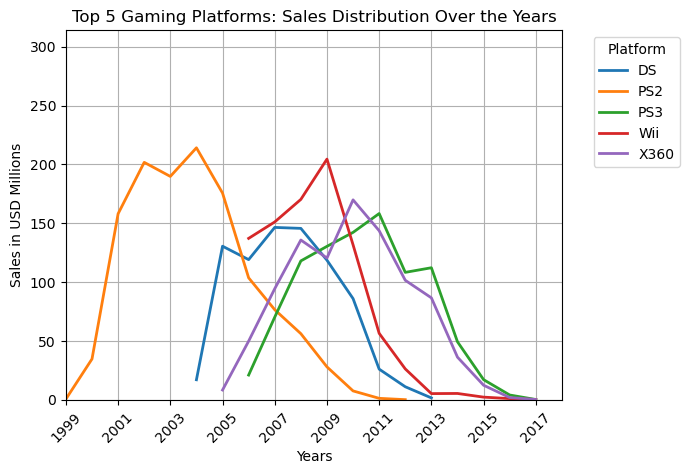

In [827]:
# Taking the top 5 platforms and creating a distribution based off total sales per year

# Calculate total sales for each platform
total_sales_per_platform = DF.groupby('platform')['total_sales'].sum()

# Get the top 5 platforms by total sales
top_5_platforms = total_sales_per_platform.nlargest(5).index

# Filter the DF to include only the top 5 platforms
DF_top5 = DF[DF['platform'].isin(top_5_platforms)]

# Pivot filtered data to get platforms as columns
platform_sales_top5 = DF_top5.pivot_table(index='year_of_release', columns='platform',values='total_sales',aggfunc='sum')

# Plotting each platform
ax = platform_sales_top5.plot(
    kind='line',
    xlim=[1999, 2018],  # Setting the range for years
    ylim=[0, platform_sales_top5.max().max() + 100],  # Setting the range for sales in millions
    grid=True,
    linewidth=2, # Optional: line width for better visibility
)

plt.xticks(range(1999,2019,2), rotation=45)

plt.title("Top 5 Gaming Platforms: Sales Distribution Over the Years")
plt.xlabel("Years")
plt.ylabel("Sales in USD Millions")
plt.legend(title='Platform', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [828]:
# Find Platforms that used to be popular but now have zero sales

# List all unique platforms in the dataset
all_platforms = DF['platform'].unique()

#Calculate total sales per platform per year
platform_year_sales = DF.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()

# Identify platforms that had sales before 2017
popular_platforms_before_2017 = platform_year_sales[(platform_year_sales['year_of_release'] < 2017) & (platform_year_sales['total_sales'] > 0)]['platform'].unique()

# Identify platforms with sales data in 2017
platforms_in_2017 = platform_year_sales[platform_year_sales['year_of_release'] == 2017]['platform'].unique()

# Platforms that had entries before 2017 but are missing in 2017
popular_platforms_before_2017_set = set(popular_platforms_before_2017)
platforms_in_2017_set = set(platforms_in_2017)
missing_platforms_2017 = list(popular_platforms_before_2017_set - platforms_in_2017_set)
print("Platforms missing in 2017 that were once popular:", missing_platforms_2017)


Platforms missing in 2017 that were once popular: ['DS', 'DC', 'NG', '3DO', 'PCFX', 'N64', 'PS', 'XB', 'SNES', '3DS', 'PS2', 'GBA', 'WS', 'SCD', 'GG', 'SAT', 'TG16', 'GEN', '2600', 'GB', 'GC', 'NES', 'PSP']


In [829]:
# Calculate lifespan for missing platforms

missing_platform_lifespan = platform_year_sales[platform_year_sales['platform'].isin(missing_platforms_2017)]
missing_platform_lifespan = missing_platform_lifespan.groupby('platform')['year_of_release'].agg(['min', 'max']).reset_index()
missing_platform_lifespan['lifespan_years'] = missing_platform_lifespan['max'] - missing_platform_lifespan['min']

# Print the lifespan of missing platforms
print(missing_platform_lifespan.sort_values(by='lifespan_years', ascending=False))

   platform   min   max  lifespan_years
4        DS  1985  2013              28
14       PS  1994  2012              18
5        GB  1988  2001              13
15      PS2  1999  2012              13
11      NES  1983  1994              11
16      PSP  2004  2015              11
19     SNES  1990  2000              10
3        DC  1998  2008              10
0      2600  1980  1989               9
6       GBA  2000  2007               7
22       XB  2001  2008               7
10      N64  1996  2002               6
7        GC  2001  2007               6
17      SAT  1994  2000               6
2       3DS  2011  2016               5
8       GEN  1990  1994               4
12       NG  1993  1996               3
21       WS  1999  2001               2
1       3DO  1994  1995               1
18      SCD  1993  1994               1
9        GG  1992  1992               0
13     PCFX  1996  1996               0
20     TG16  1995  1995               0


In [830]:
# Now find how long it generally takes for new platforms to appear and old ones to fade

# Calculate the first and last apearance of each platform
platform_lifespan = DF.groupby('platform')['year_of_release'].agg(['min','max']).reset_index()
platform_lifespan.columns = ['platform', 'first_appearance', 'last_appearance']
platform_lifespan['lifespan'] = platform_lifespan['last_appearance'] - platform_lifespan['first_appearance']

# Check calculations
print(platform_lifespan)

   platform  first_appearance  last_appearance  lifespan
0      2600              1980             1989         9
1       3DO              1994             1995         1
2       3DS              2011             2016         5
3        DC              1998             2008        10
4        DS              1985             2013        28
5        GB              1988             2001        13
6       GBA              2000             2007         7
7        GC              2001             2007         6
8       GEN              1990             1994         4
9        GG              1992             1992         0
10      N64              1996             2002         6
11      NES              1983             1994        11
12       NG              1993             1996         3
13       PC              1985             2017        32
14     PCFX              1996             1996         0
15       PS              1994             2012        18
16      PS2              1999  

In [831]:
# Find the year when each platform first appeared
new_platforms = platform_lifespan[['platform', 'first_appearance']].sort_values(by='first_appearance')

# Calculate the intervals between new platform introductions
new_platforms['introduction_interval'] = new_platforms['first_appearance'].diff().fillna(0).astype(int)

# Check calculations
print(new_platforms)

   platform  first_appearance  introduction_interval
0      2600              1980                      0
11      NES              1983                      3
4        DS              1985                      2
13       PC              1985                      0
5        GB              1988                      3
23     SNES              1990                      2
8       GEN              1990                      0
9        GG              1992                      2
22      SCD              1993                      1
12       NG              1993                      0
21      SAT              1994                      1
15       PS              1994                      0
1       3DO              1994                      0
24     TG16              1995                      1
14     PCFX              1996                      1
10      N64              1996                      0
3        DC              1998                      2
25       WS              1999                 

In [832]:
# Find the average length of time for new platforms to appear
average_interval = new_platforms['introduction_interval'].mean().astype(int)

# Display the average length of time for new platforms to appear
print(average_interval)

1


In [833]:
# Take into consideration the standard deviation
average_interval_std = new_platforms['introduction_interval'].std()
print(average_interval_std)

print(f"The average length of time for new platforms to appear, and old ones to fade out, is about 1-2 years.")

1.2092830898502835
The average length of time for new platforms to appear, and old ones to fade out, is about 1-2 years.


In [834]:
# Moving forward we should only use data from 2010-2017, this is the time period where the most growth for sales and development of different platforms and games saw a surge of growth.

# Create the dataframe we will be focusing on moving forward
DF_new = DF[(DF['year_of_release'] >= 2010) & (DF['year_of_release']<= 2017)]

# Put the new dataframe in chronological order based on the year_of_release column
DF_new_sorted = DF_new.sort_values(by='year_of_release', ascending=True)

# Display new dataframe
print(DF_new_sorted)

                                                    name platform  \
14                                    Kinect Adventures!     X360   
10791                         iCarly 2: iJoin The Click!      Wii   
10796                                Dora's Cooking Club       DS   
10811  Tennis no Oji-Sama: Motto Gakuensai no Ouji-Sa...       DS   
4183                                          FlingSmash      Wii   
...                                                  ...      ...   
16585                      Farming 2017 - The Simulation      PS4   
11571                           Earth Defense Force 2017     X360   
8009                                     Just Dance 2017      Wii   
14294                                    Just Dance 2017      PS4   
9465                           Pro Evolution Soccer 2017      PS3   

       year_of_release       genre  na_sales  eu_sales  jp_sales  other_sales  \
14                2010        Misc     15.00      4.89      0.24         1.69   
10791    

In [835]:
# Find which platforms are leading in sales within new dataframe
leading_platforms = DF_new_sorted.groupby(['platform'])['total_sales'].sum().reset_index()

# Display data for platform sales within the new dataframe
print(leading_platforms.sort_values(by='total_sales', ascending=False))

# The top 5 leading platforms in sales are PS3, X360, PS4, 3DS, Wii, XOne, and DS

   platform  total_sales
5       PS3       591.26
11     X360       551.99
6       PS4       312.32
0       3DS       257.70
9       Wii       228.08
12     XOne       159.32
1        DS       124.47
2        PC       120.47
10     WiiU        82.19
7       PSP        65.48
8       PSV        53.46
4       PS2         8.72
3        PS         0.37


In [836]:
# Which platforms are growing and which are shrinking

# Calculate the total annual sales for each platform
annual_platform_sales = DF_new_sorted.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()

# Display calculations
print(annual_platform_sales)

   platform  year_of_release  total_sales
0       3DS             2011        63.18
1       3DS             2012        51.12
2       3DS             2013        56.56
3       3DS             2014        43.95
4       3DS             2015        27.75
..      ...              ...          ...
70     XOne             2013        19.12
71     XOne             2014        53.25
72     XOne             2015        60.38
73     XOne             2016        26.50
74     XOne             2017         0.07

[75 rows x 3 columns]


In [837]:
# Pivot the data to see sales trends over time
sales_trend_pivot = annual_platform_sales.pivot(index='year_of_release', columns='platform', values='total_sales')

# Calculate year-over-year growth for each platform
sales_trend = sales_trend_pivot.pct_change()

# Determine if platforms are growing or shrinking based on recent years performance
platform_trend = sales_trend.mean().sort_values(ascending=False).reset_index()
platform_trend.columns = ['platform', 'average_growth']

# Display calculation
print(platform_trend)
# From this data the top growing platforms for the designated time period are PS4, XOne, PSV, and PS
# From the data the top shrinking platforms for the designated time period are Wii, X360, PSP, PS3, WiiU, DS, PC

   platform  average_growth
0       PS4        0.356500
1      XOne        0.090117
2       PSV        0.071978
3        PS        0.000000
4       3DS       -0.188405
5       PS2       -0.255914
6        PC       -0.278380
7        DS       -0.304822
8      WiiU       -0.332502
9       PS3       -0.443098
10      PSP       -0.459409
11     X360       -0.514236
12      Wii       -0.550118


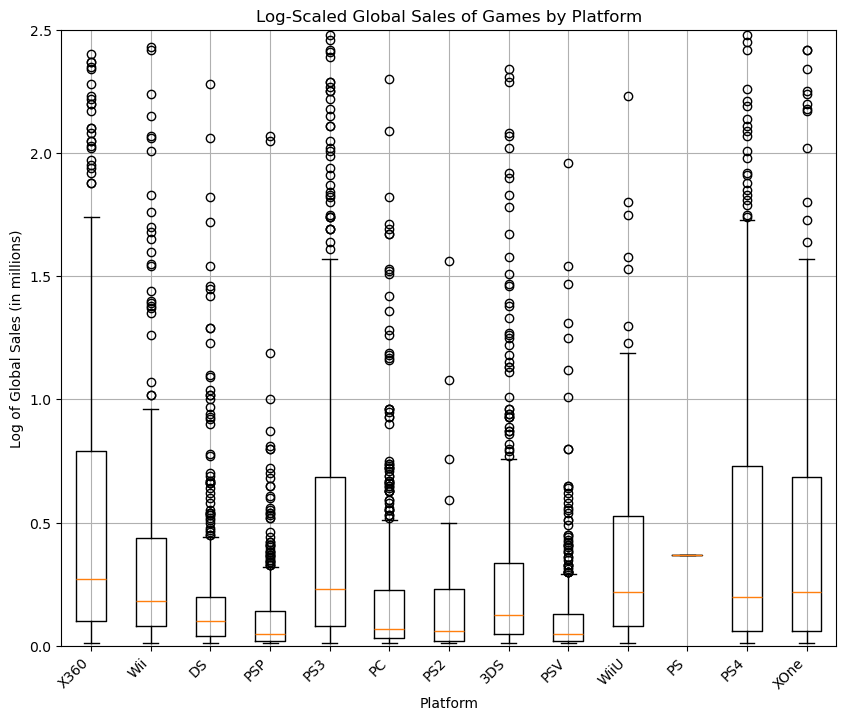

In [846]:
# Taking the global sales of all games from the new dataframe, create a boxplot

# Calculate the global sales for each platform
global_platform_sales = DF_new_sorted.groupby(['platform'])['total_sales'].sum().reset_index()

DF_new_sorted['log_total_sales'] = np.log1p(DF_new_sorted['total_sales'])

# Create a boxplot
plt.figure(figsize=(10, 8))
plt.boxplot([DF_new_sorted[DF_new_sorted['platform'] == platform]['total_sales'] for platform in DF_new_sorted['platform'].unique()],
            labels=DF_new_sorted['platform'].unique())
plt.title("Log-Scaled Global Sales of Games by Platform")
plt.xlabel("Platform")
plt.ylabel("Log of Global Sales (in millions)")
plt.grid(True)
plt.ylim(0, 2.5)
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# From the boxplot you can see significant differences in sales, which also helps to visualize the platforms that have sales that are continuing to grow and the ones that are shrinking. Even with the outliers, the boxplot stays true to the growth and shrinking values found previously. 

In [850]:
# Take into consideration the average sales (USD Millions) on various platforms

# Find the average global sales for individual platforms
avg_global_platform_sales = global_platform_sales.groupby(['platform'])['total_sales'].mean().reset_index()
print(avg_global_platform_sales)

   platform  total_sales
0       3DS       257.70
1        DS       124.47
2        PC       120.47
3        PS         0.37
4       PS2         8.72
5       PS3       591.26
6       PS4       312.32
7       PSP        65.48
8       PSV        53.46
9       Wii       228.08
10     WiiU        82.19
11     X360       551.99
12     XOne       159.32


In [ ]:
# From previous analysis the data showing the top growing platforms for the designated time period were PS4, XOne, PSV,and PS
# It does need to be taken into consideration the time in which the platform was released and how long between release and the introduction of a new platform
# The PS4 and the XOne were both released in 2013 which would directly cause competition of sales between the two systems, they are both newer platforms for the designated time period that it would make sense that their average sales are not the highest 
# The PSV was released in 2011, but two years later the PS4 and XOne were released. This is a direct explanation as to why the average sales for this platform are significantly lower for one that showed growth as opposed to shrinkage in sales
# The PS was released in 1994, but so were two other platforms that are not displayed in this data set; the SAT and 3DO which caused direct competition between these three platforms. Not to mention that in 1995, one year later, a new platform was released, TG16. 

In [ ]:
# From previous analysis the data showing the top shrinking platforms for the designated time period were Wii, X360, PSP, PS3, WiiU, DS, and PC
# It would make sense that the average golbal sales for these platforms would be higher due to the length of time they were on the market before the release of a new platform.
# In 1985, both the DS and PC were released and show almost identical average sales (the DS only leading by $4 USD Millions). This platform was the only system out until 1988, causing them to be the only two systems games were, at the time, being produced for. 
# From 1988-2001, a new platform was being released every year back to back which would explain why those individual platforms are not on this data set, there was constant competition and no room for sole focus and development of games for just one system, companies were trying to keep up with popularity and demand.
# Then in 2004, three years after the newest platform (XB) was released, a brand new system hit the market; the PSP (this system allowed gamers to take their games with them in a portable hand held device). The convenience and easy access of this device would explain the large amount of sales in just one year. 
# To keep up with competition, X360 came out in 2005. Both systems started polarizing the market with games specifically only accessible on their systems, this created a divide in preference within the gaming world. For Xbox, games like Halo, Gears of War, and Mass Effect caused strong allegiance for this particular population of gamers. 
# In 2006, two new systems were released to keep up with competition and demand; the Wii, and the PS3. Wii was a system that was unlike any other on the market, it involved direct physical interaction from the gamer and the game, this new type of system and concept would explain the huge average sales. To keep up with the competition between Xbox and Playstation, Playstation released the PS3 along with system specific games like Uncharted, The Last of Us, and Gran Turismo 5. All of which were tremendous successes and created a huge following for these specific games. This would explain the huge average sales for this particular gaming system. 
# Until 2011, the PS3 and Wii were the only newer gaming platforms on the market, this is a five year time span for sales to grow, which is exactly what it did. 
# In 2011, the PSV was released, and was met with an immediately strong commercial success. 
# In 2012, the WiiU was released, it had great commercial success for multiple reasons, it was a portable gaming system that had access to all Wii games with a large amount of nostalgic games like Mario Kart 8, Super Mario 3D World, Super Smash Bros, and The Legend of Zelda: The Wind Waker HD. It was also the only new platform on the market until 2013, allowing it to accumulate a large amount of sales in that time period. 